In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import shap

In [2]:
os.chdir('..')
path = os.getcwd()

In [3]:

train_df = pd.read_csv(path+'\\Project_files\\application_train.csv')
test_df = pd.read_csv(path+'\\Project_files\\application_test.csv')

In [4]:
print(train_df.info())
train_df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

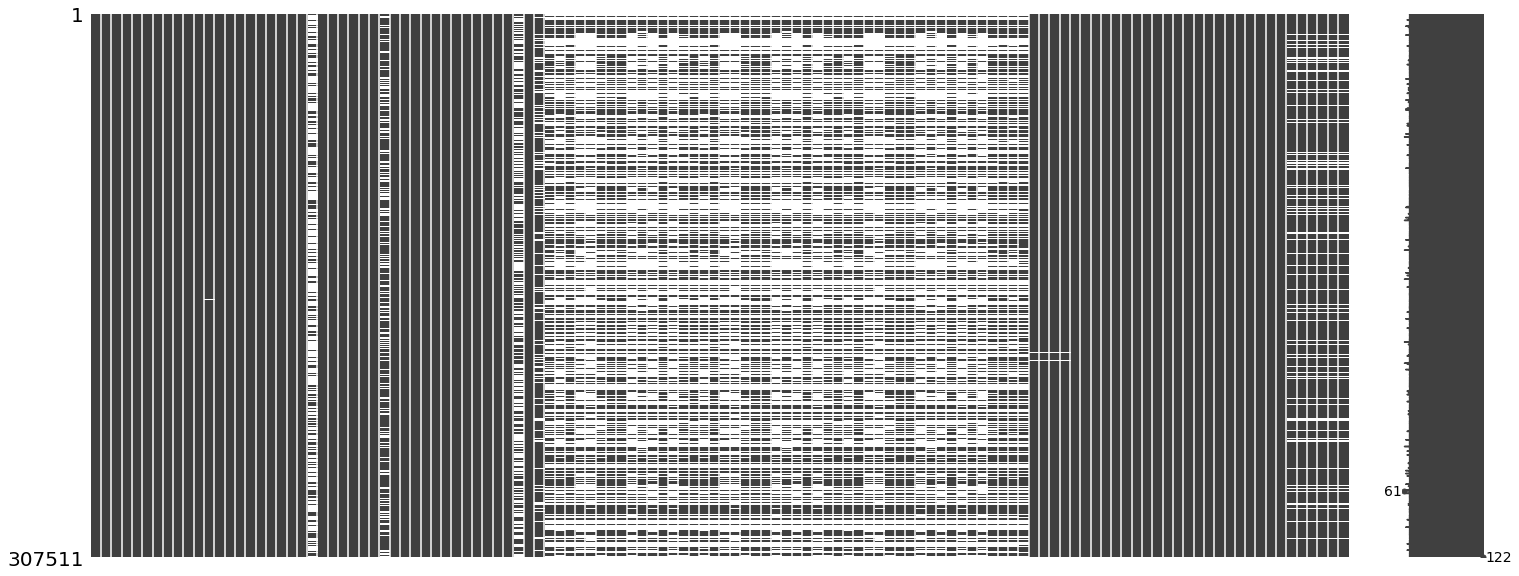

In [5]:
msno.matrix(train_df)

In [6]:
train_df['TARGET'].value_counts()/train_df.shape[0]

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [7]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def preprocessing(df, imputer = False):
    #set the index as the id of the loan
    df.set_index('SK_ID_CURR')
    #wrong gender code
    df = df.drop(df.loc[df['CODE_GENDER'] == 'XNA'].index)
    #check if binary features are binary
    binary = [i for i in df.columns if 'FLAG' in i]
    for i in binary:
        if len(df[i].unique()) != 2:
            print('Column {} is not binary.'.format(i))
    #extract target
    if df['TARGET'].isna().sum() != 0:
        df = df.drop(df.loc[df['TARGET'].isna()])
    y = df['TARGET']
    df = df.drop(labels = 'TARGET', axis = 1)
    #OHE categorical features
    cat_df = df.select_dtypes(include = ['object'])
    num_df = df.select_dtypes(exclude = ['object'])
    ohe = OneHotEncoder(sparse = False)
    cat_df = ohe.fit_transform(cat_df)
    colnames = ohe.get_feature_names_out(ohe.feature_names_in_)
    cat_df = pd.DataFrame(cat_df, columns = colnames)
    #impute
    if imputer:
        num_df = imputer.fit_transform(num_df)
        colnames = imputer.feature_names_in_
        num_df = pd.DataFrame(num_df, columns = colnames)
        
    df = num_df.join(cat_df)

    colnames = df.columns
    return df, y, colnames 
    
    

In [9]:
scaler = StandardScaler()
xgboost = xgb.XGBClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ('classifier', xgboost)])

In [10]:
df, df_y, df_colnames = preprocessing(train_df)
xtrain, xtest, ytrain, ytest = train_test_split(df, df_y, random_state = 38)
pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9204703617466863

In [46]:
def fit_and_score(df, target, test, target_test, pipe, random_state = 38, resampled = False):
    fig, ax = plt.subplots(2,2,figsize=(15, 10))
    ax[0,0].pie(target.value_counts(),
       labels=target.unique(),
       autopct='%1.2f%%',
       textprops={'fontsize':15,
                  'color': 'w'}        
       )
    if resampled : 
        xtrain = df
        ytrain = target
        xtest = test
        ytest = target_test
        pipe.fit(df, target)
        ypred = pipe.predict(test)
        yproba = pipe.predict_proba(test)
        tr_yproba = pipe.predict_proba(df) 
    else:
        xtrain, xtest, ytrain, ytest = train_test_split(df, target, random_state=random_state)
        pipe.fit(xtrain, ytrain)
        ypred = pipe.predict(xtest)
        yproba = pipe.predict_proba(xtest)
        tr_yproba = pipe.predict_proba(xtrain)
    
    print(classification_report(ytest, ypred))
    
    tr_fpr, tr_tpr, tr_thersh = metrics.roc_curve(ytrain, tr_yproba[:,1])
    tr_roc_auc = round(metrics.auc(tr_fpr, tr_tpr),3)
    
    fpr, tpr, thresh = metrics.roc_curve(ytest, yproba[:,1])
    roc_auc = round(metrics.auc(fpr, tpr), 3)
    gmean = np.sqrt(tpr * (1 - fpr))
    max_gmean = np.argmax(gmean)
    opti_thresh = thresh[max_gmean]
    opti_fpr = fpr[max_gmean]
    opti_tpr = tpr[max_gmean]

    ax[0,1].plot(fpr, tpr)
    ax[0,1].plot(tr_fpr, tr_tpr)
    ax[0,1].plot(opti_fpr, opti_tpr, marker='o')
    ax[0,1].text(0.4,0.1,'Train AUC : {} / Test AUC : {}'.format(tr_roc_auc, roc_auc))
    ax[0,1].text(opti_fpr+.05, opti_tpr+.05, 'Optimal threshold : {}'.format(round(opti_thresh,4)))
    
    ConfusionMatrixDisplay.from_predictions(ytest, ypred, normalize = 'true', ax=ax[1,0])
    ConfusionMatrixDisplay.from_predictions(ytest, yproba[:,1] >= opti_thresh, normalize = 'true', ax=ax[1,1])
    print(classification_report(ytest, yproba[:,1] >= opti_thresh))
    plt.show()
    
    def shap_expl(xtrain, xtest, ytest, pipe):
        
        explainer = shap.TreeExplainer(pipe['classifier'], data = xtrain,  model_output = 'predict_proba')

        shap_values = explainer.shap_values(xtest, y=ytest)
        shap.summary_plot(shap_values, xtest, feature_names = df_colnames)
        
    shap_expl(xtrain, xtest, ytest, pipe)

    
    

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70773
           1       0.49      0.03      0.06      6104

    accuracy                           0.92     76877
   macro avg       0.71      0.52      0.51     76877
weighted avg       0.89      0.92      0.89     76877

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     70773
           1       0.16      0.69      0.25      6104

    accuracy                           0.68     76877
   macro avg       0.56      0.68      0.52     76877
weighted avg       0.90      0.68      0.75     76877



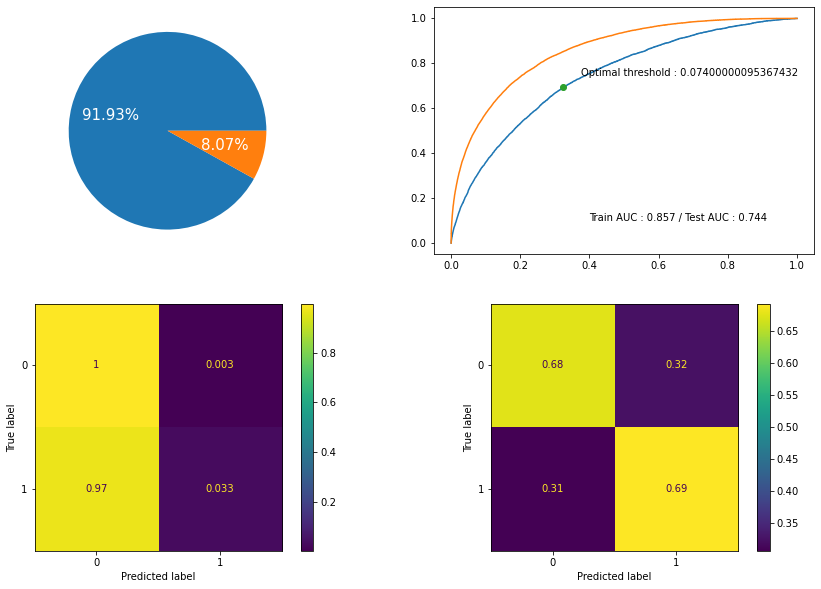

100%|===================| 76718/76877 [03:49<00:00]        

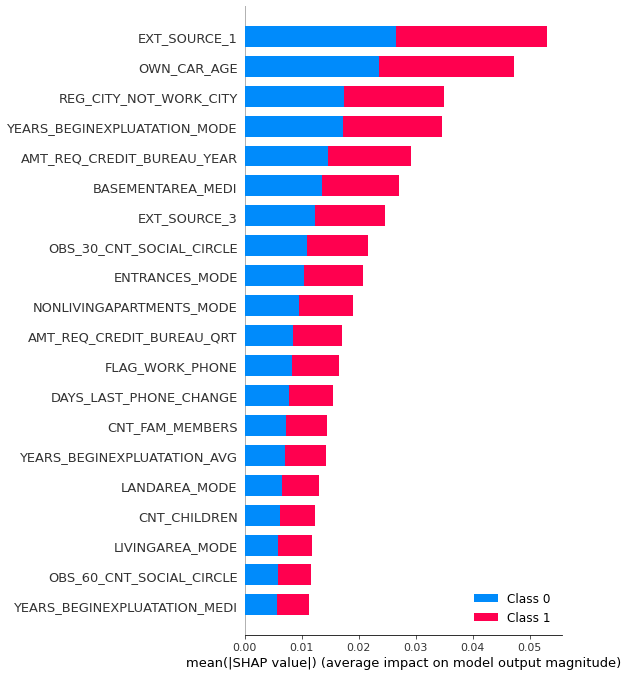

In [12]:
fit_and_score(df, df_y, pipe)

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     70773
           1       0.17      0.61      0.26      6104

    accuracy                           0.73     76877
   macro avg       0.56      0.68      0.55     76877
weighted avg       0.89      0.73      0.79     76877

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     70773
           1       0.15      0.68      0.25      6104

    accuracy                           0.68     76877
   macro avg       0.56      0.68      0.52     76877
weighted avg       0.90      0.68      0.75     76877



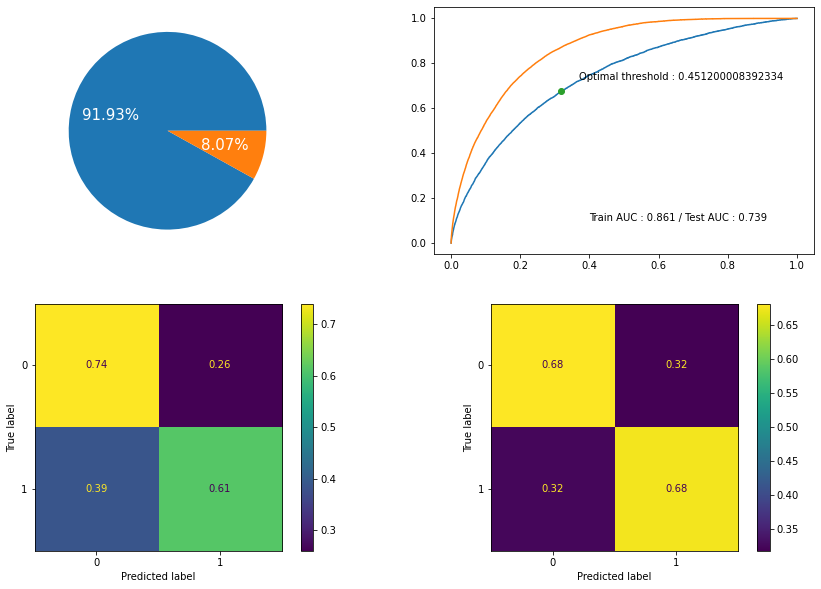

100%|===================| 76766/76877 [03:39<00:00]        

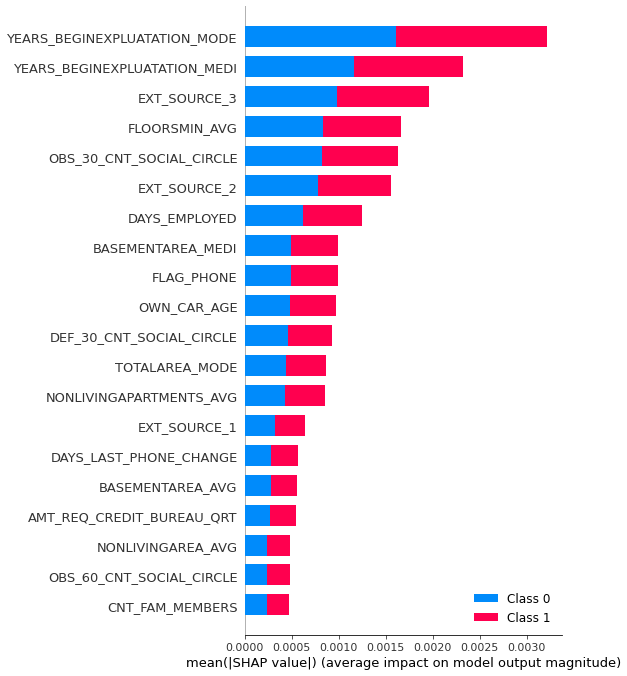

In [13]:
#let's try sample weight
ratio = df_y.value_counts()[0] / df_y.value_counts()[1]

pipe_w = pipe.set_params(classifier__scale_pos_weight = ratio)

fit_and_score(df, df_y, pipe_w)

In [44]:
#let's try random over sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

ros = RandomOverSampler(sampling_strategy= 0.5)
rus = RandomUnderSampler(sampling_strategy= 1.0)

samp_pipe = make_pipeline(ros, rus)
xtrain, xtest, ytrain, ytest = train_test_split(df, df_y)
samp_df, samp_df_y = samp_pipe.fit_resample(xtrain, ytrain)

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     70689
           1       0.19      0.47      0.27      6188

    accuracy                           0.80     76877
   macro avg       0.57      0.65      0.58     76877
weighted avg       0.89      0.80      0.83     76877

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     70689
           1       0.15      0.64      0.24      6188

    accuracy                           0.68     76877
   macro avg       0.55      0.66      0.52     76877
weighted avg       0.89      0.68      0.75     76877



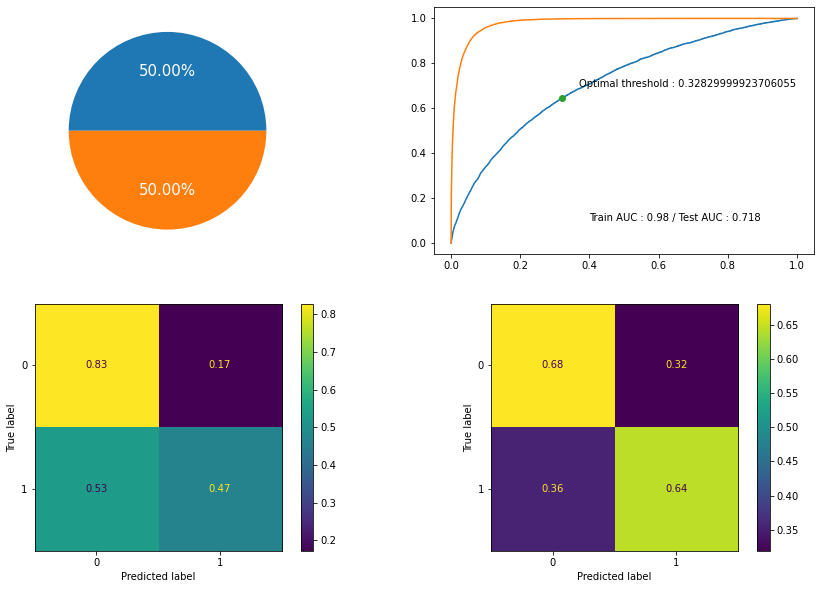

  8%|==                  | 5945/76877 [01:21<16:06]       

In [ ]:

fit_and_score(samp_df,samp_df_y, xtest, ytest, pipe, resampled=True)

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     35291
           1       0.74      0.77      0.75     35380

    accuracy                           0.75     70671
   macro avg       0.75      0.75      0.75     70671
weighted avg       0.75      0.75      0.75     70671

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     35291
           1       0.74      0.77      0.75     35380

    accuracy                           0.75     70671
   macro avg       0.75      0.75      0.75     70671
weighted avg       0.75      0.75      0.75     70671



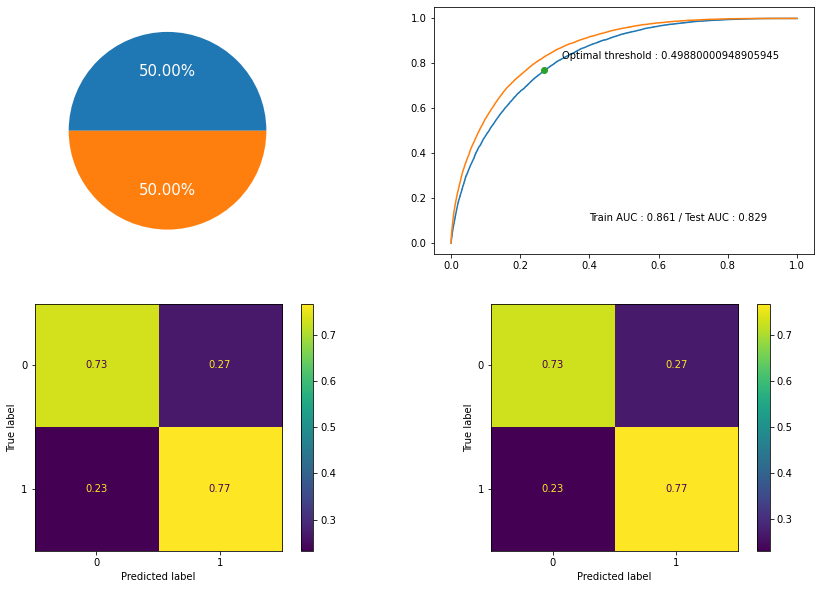

100%|===================| 70378/70671 [03:28<00:00]        

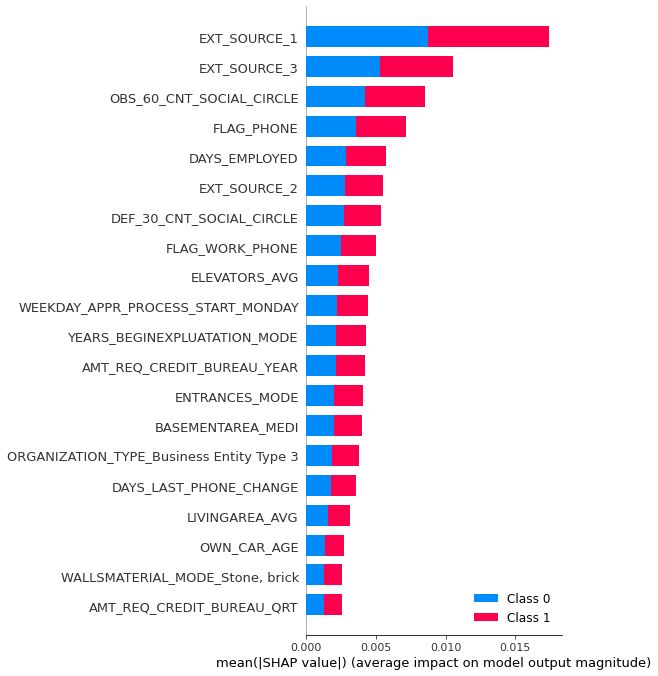

In [26]:
#let's try combining both methods

ratio = samp_df_y.value_counts()[0] / samp_df_y.value_counts()[1]
pipe_w = pipe.set_params(classifier__scale_pos_weight = ratio)
fit_and_score(samp_df,samp_df_y, pipe_w)

In [27]:
#let's do simple imputer for now
from sklearn.impute import SimpleImputer
SImputer = SimpleImputer(strategy='median')
imp_df, imp_df_y, imp_colnames = preprocessing(train_df, imputer=SImputer)



              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70773
           1       0.49      0.04      0.07      6104

    accuracy                           0.92     76877
   macro avg       0.71      0.52      0.51     76877
weighted avg       0.89      0.92      0.89     76877

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70773
           1       0.16      0.67      0.26      6104

    accuracy                           0.69     76877
   macro avg       0.56      0.68      0.53     76877
weighted avg       0.90      0.69      0.76     76877



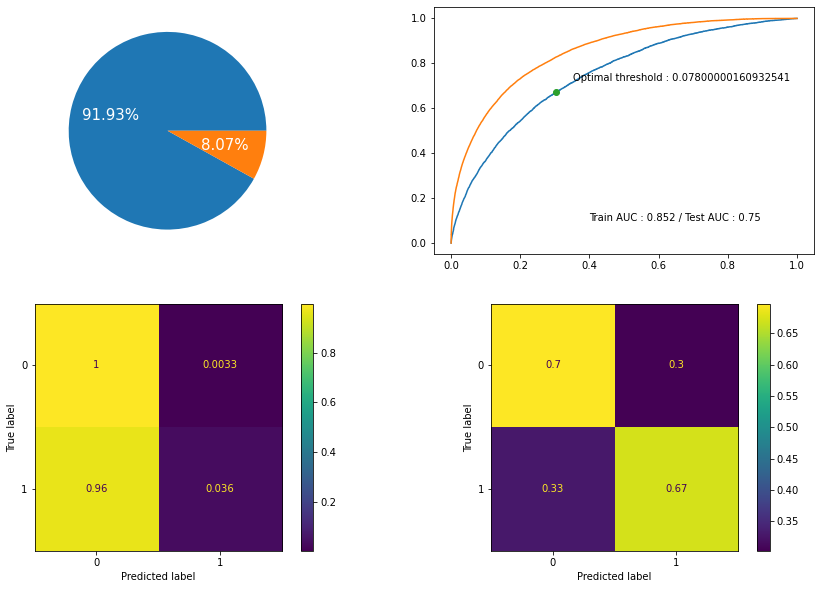

 99%|===================| 76391/76877 [02:41<00:01]        

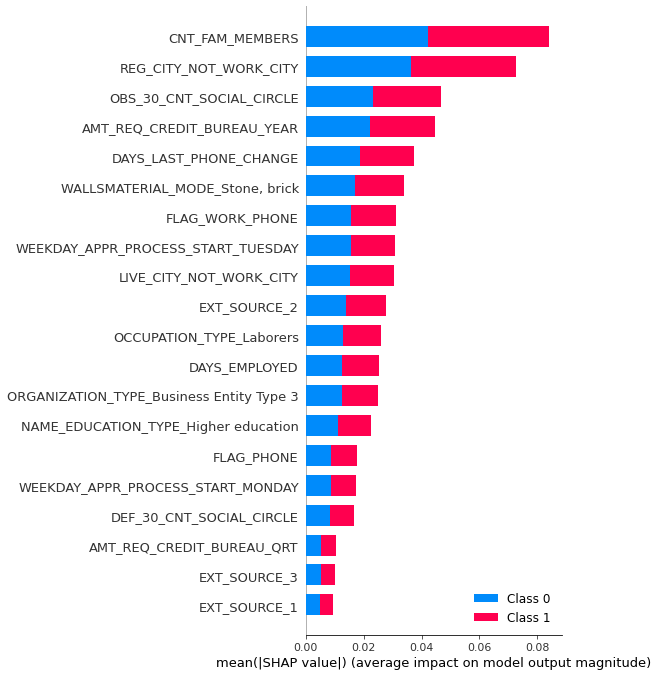

In [28]:
fit_and_score(imp_df, imp_df_y, pipe)

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     70773
           1       0.17      0.62      0.27      6104

    accuracy                           0.73     76877
   macro avg       0.56      0.68      0.55     76877
weighted avg       0.89      0.73      0.79     76877

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     70773
           1       0.16      0.68      0.26      6104

    accuracy                           0.69     76877
   macro avg       0.56      0.68      0.53     76877
weighted avg       0.90      0.69      0.76     76877



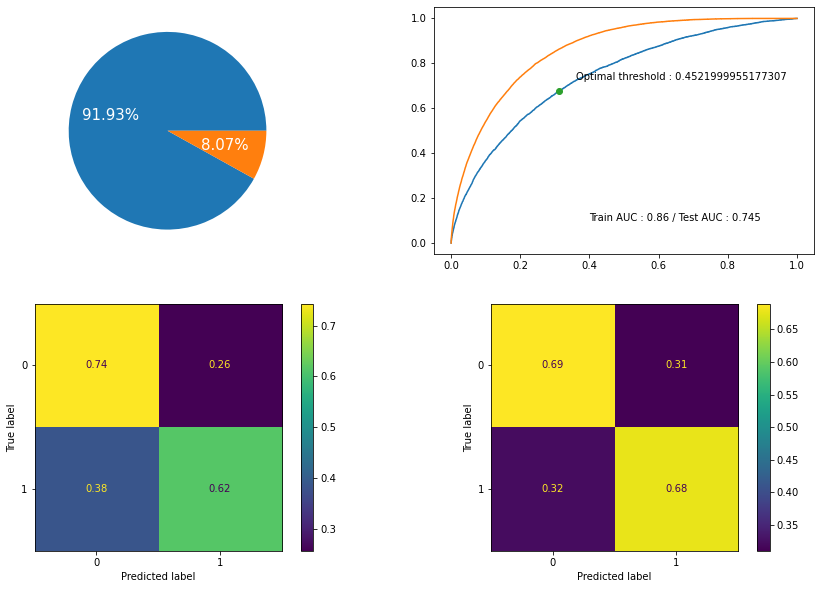

100%|===================| 76762/76877 [02:40<00:00]        

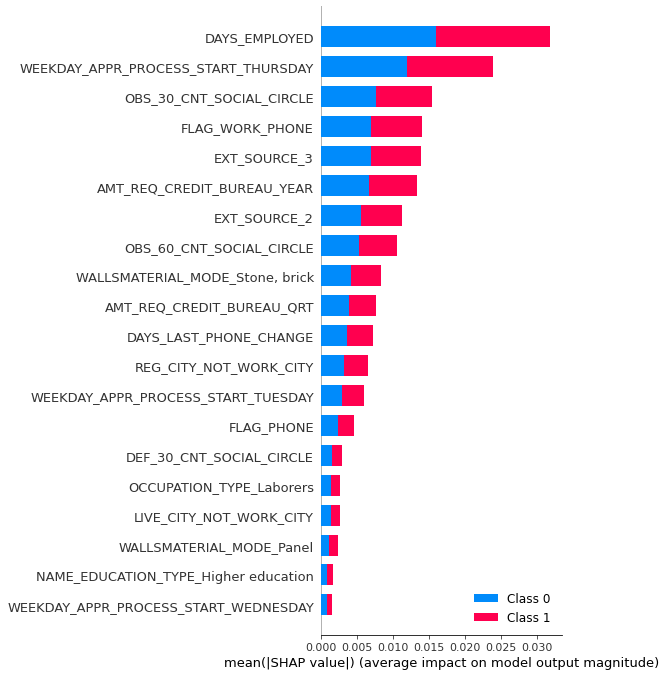

In [29]:
ratio = imp_df_y.value_counts()[0] / imp_df_y.value_counts()[1]

pipe_w = pipe.set_params(classifier__scale_pos_weight = ratio)

fit_and_score(imp_df, imp_df_y, pipe_w)

              precision    recall  f1-score   support

           0       1.00      0.19      0.32     35291
           1       0.55      1.00      0.71     35380

    accuracy                           0.60     70671
   macro avg       0.77      0.60      0.52     70671
weighted avg       0.77      0.60      0.52     70671

              precision    recall  f1-score   support

           0       0.76      0.72      0.74     35291
           1       0.73      0.78      0.76     35380

    accuracy                           0.75     70671
   macro avg       0.75      0.75      0.75     70671
weighted avg       0.75      0.75      0.75     70671



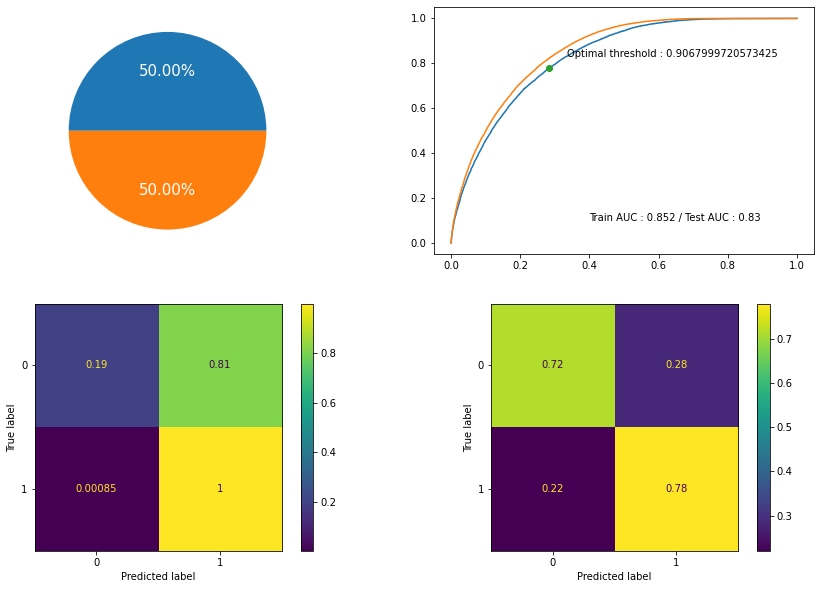

 99%|===================| 70207/70671 [02:25<00:00]        

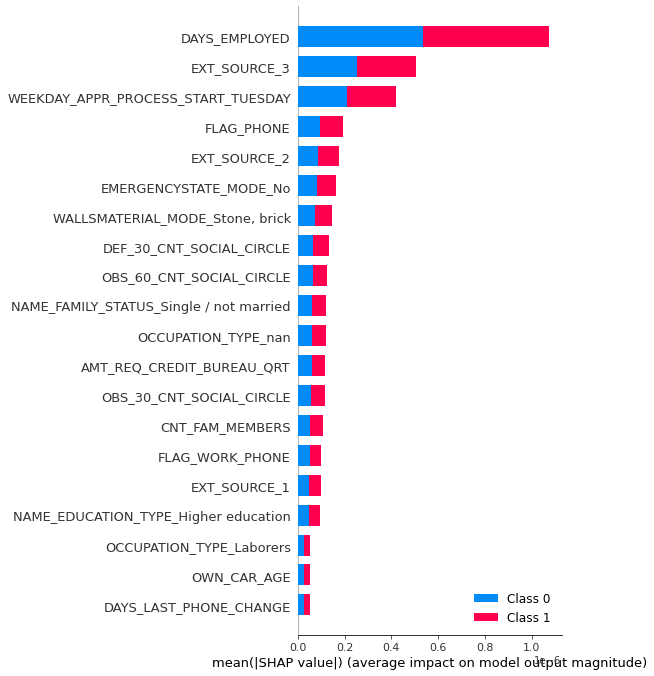

In [30]:
samp_imp_df, samp_imp_df_y = samp_pipe.fit_resample(imp_df, imp_df_y)
fit_and_score(samp_imp_df,samp_imp_df_y, pipe)

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     35291
           1       0.74      0.76      0.75     35380

    accuracy                           0.75     70671
   macro avg       0.75      0.75      0.75     70671
weighted avg       0.75      0.75      0.75     70671

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     35291
           1       0.74      0.78      0.76     35380

    accuracy                           0.75     70671
   macro avg       0.75      0.75      0.75     70671
weighted avg       0.75      0.75      0.75     70671



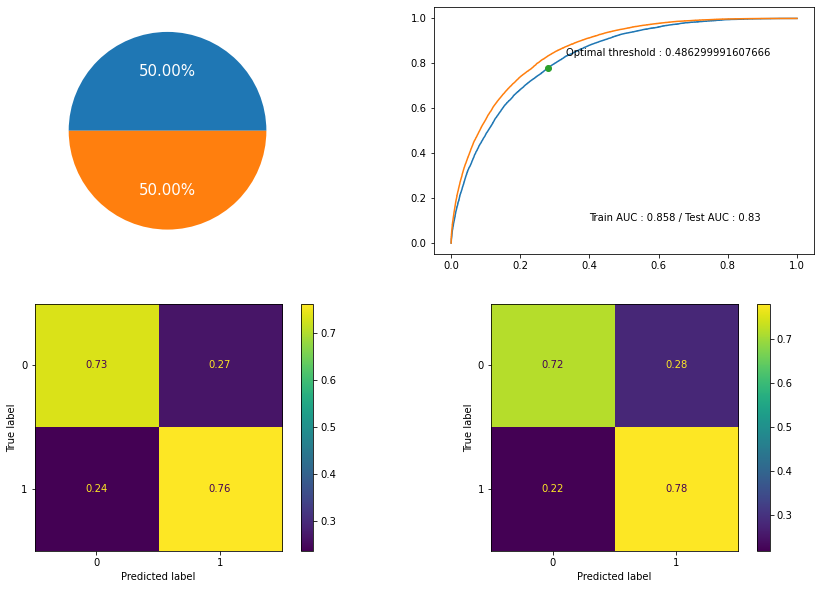

100%|===================| 70425/70671 [02:27<00:00]        

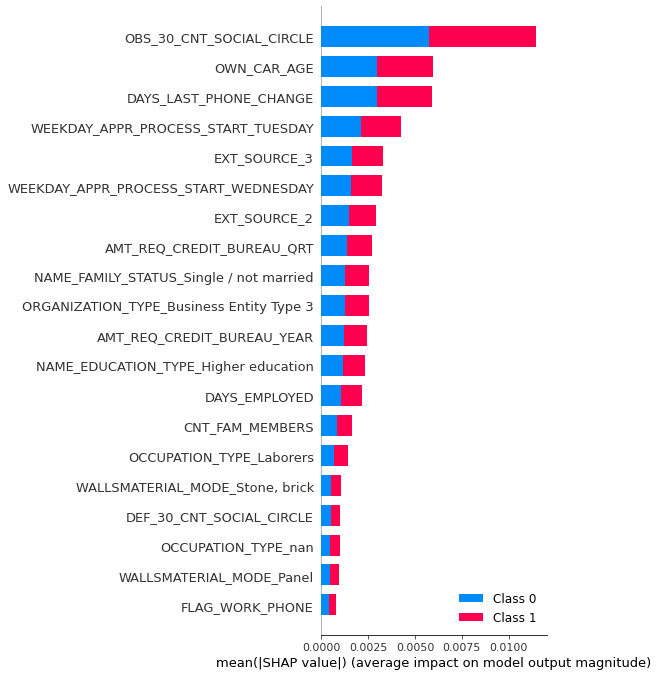

In [31]:
ratio = samp_imp_df_y.value_counts()[0] / samp_imp_df_y.value_counts()[1]

pipe_w = pipe.set_params(classifier__scale_pos_weight = ratio)

fit_and_score(samp_imp_df, samp_imp_df_y, pipe_w)


KeyboardInterrupt



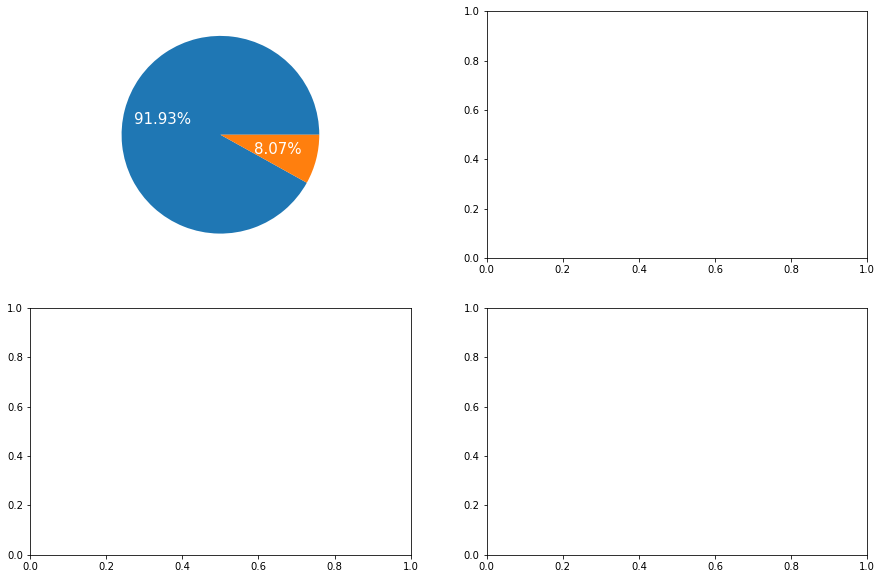

In [20]:
#let's try to improves scores on class 1 with sampling
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
xgboost_w = xgb.XGBClassifier()
smoteenn = SMOTEENN()

pipe_samp = make_pipeline(smoteenn, scaler, xgboost_w)

fit_and_score(imp_df, imp_df_y, pipe_samp)

In [39]:
#best setting is combine ros and rus and sample weights let's grid cv the hyperparameters

param_grid = {'classifier__n_estimators' : list(np.arange(1,250,25))}

grid = GridSearchCV(pipe_w, param_grid, scoring = 'roc_auc', verbose = 2)
grid.fit(samp_df, samp_df_y)

print('Best params on training set : {}'.format(grid.best_params_))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .........................classifier__n_estimators=1; total time=   6.0s
[CV] END .........................classifier__n_estimators=1; total time=   6.2s
[CV] END .........................classifier__n_estimators=1; total time=   5.9s
[CV] END .........................classifier__n_estimators=1; total time=   5.6s
[CV] END .........................classifier__n_estimators=1; total time=   5.7s
[CV] END ........................classifier__n_estimators=26; total time=  23.8s
[CV] END ........................classifier__n_estimators=26; total time=  21.9s
[CV] END ........................classifier__n_estimators=26; total time=  23.1s
[CV] END ........................classifier__n_estimators=26; total time=  23.4s
[CV] END ........................classifier__n_estimators=26; total time=  23.8s
[CV] END ........................classifier__n_estimators=51; total time=  39.3s
[CV] END ........................classifier__n_e

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     35291
           1       0.78      0.83      0.80     35380

    accuracy                           0.80     70671
   macro avg       0.80      0.80      0.80     70671
weighted avg       0.80      0.80      0.80     70671

              precision    recall  f1-score   support

           0       0.82      0.77      0.79     35291
           1       0.78      0.83      0.80     35380

    accuracy                           0.80     70671
   macro avg       0.80      0.80      0.80     70671
weighted avg       0.80      0.80      0.80     70671



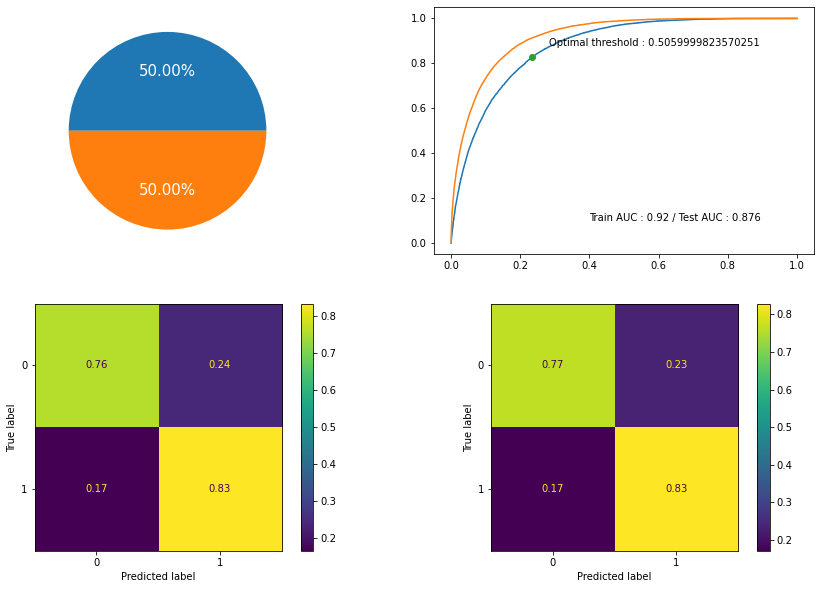

100%|===================| 70579/70671 [07:30<00:00]        

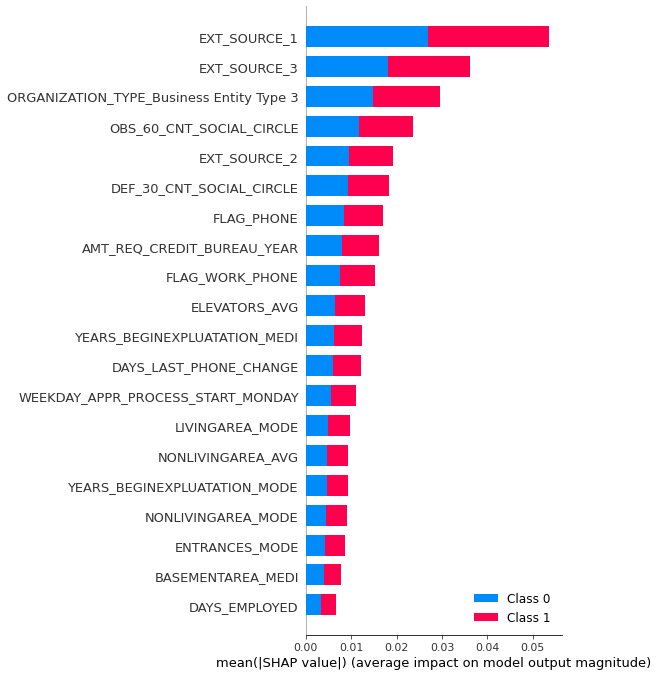

In [41]:
#best estimators is 226
pipe_w_cv = pipe_w.set_params(classifier__n_estimators = grid.best_params_['classifier__n_estimators'])
fit_and_score(samp_df,samp_df_y, pipe_w_cv)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     35291
           1       0.82      0.91      0.86     35380

    accuracy                           0.86     70671
   macro avg       0.86      0.86      0.86     70671
weighted avg       0.86      0.86      0.86     70671

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     35291
           1       0.84      0.88      0.86     35380

    accuracy                           0.86     70671
   macro avg       0.86      0.86      0.86     70671
weighted avg       0.86      0.86      0.86     70671



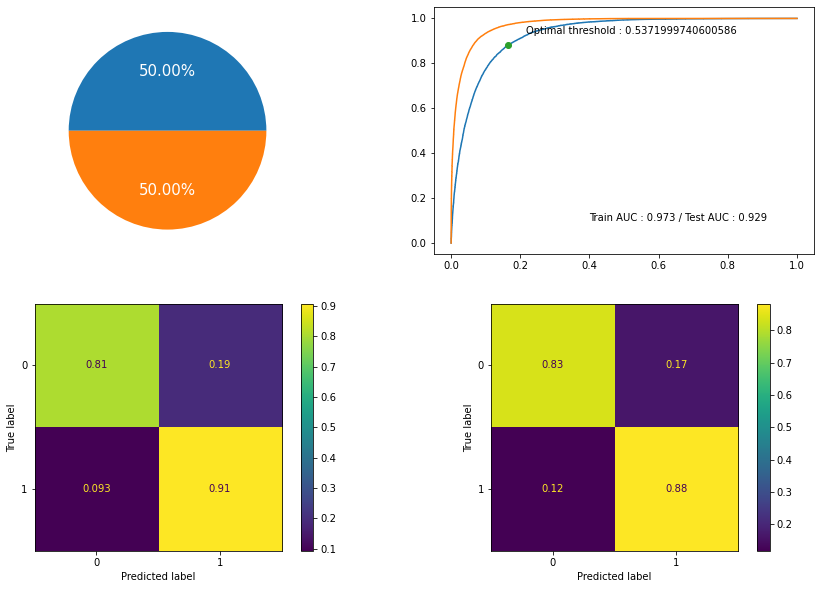

100%|===================| 70649/70671 [16:02<00:00]        

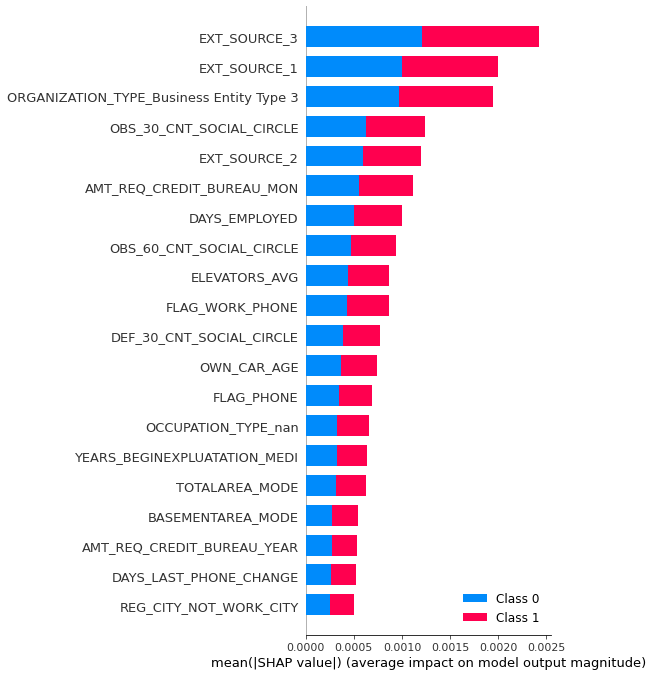

In [42]:
#let's try going crazy
pipe_w_cr = pipe_w.set_params(classifier__n_estimators = 500)
fit_and_score(samp_df,samp_df_y, pipe_w_cr)

Text(0, 0, 'auc : 0.6867382818869381')

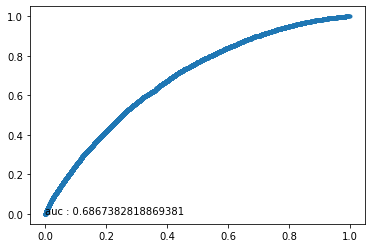

In [32]:
from sklearn import metrics
yproba = pipe.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yproba[:,1])

df_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresh':thresholds})
plt.plot(fpr, tpr, marker='.')
plt.text(0,0,'auc : {}'.format(metrics.roc_auc_score(ytest, yproba[:,1])))

In [33]:
df_roc.head(20)

,fpr,tpr,thresh
0,0.000000,0.000000,1.995791
1,0.000014,0.000000,0.995791
2,0.000028,0.000000,0.994938
3,0.000028,0.000164,0.994583
4,0.000057,0.000164,0.993522
5,0.000057,0.000491,0.992586
6,0.000071,0.000491,0.992114
7,0.000071,0.000819,0.991837
8,0.000127,0.000819,0.991129
9,0.000127,0.000983,0.990980


Text(0.8243892444858916, 1.1934796854521625, 'Optimal threshold : 0.07400000095367432')

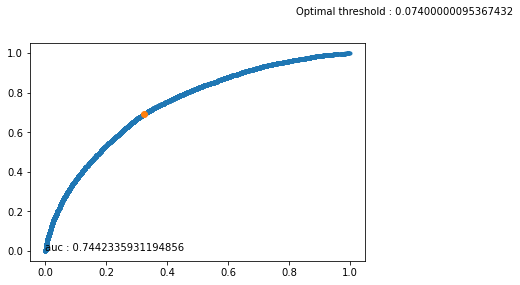

In [60]:
#determine best thresholds with g-mean
gmean = np.sqrt(tpr * (1 - fpr))
max_gmean = np.argmax(gmean)
opti_thresh = round(thresholds[max_gmean], ndigits = 4)
opti_fpr = fpr[max_gmean]
opti_tpr = tpr[max_gmean]

plt.plot(fpr, tpr, marker='.')
plt.plot(opti_fpr, opti_tpr, marker = 'o')
plt.text(0,0,'auc : {}'.format(metrics.roc_auc_score(ytest, yproba[:,1])))
plt.text(opti_fpr+.5, opti_tpr+.5, 'Optimal threshold : {}'.format(opti_thresh))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70735
           1       0.45      0.04      0.07      6143

    accuracy                           0.92     76878
   macro avg       0.68      0.52      0.51     76878
weighted avg       0.88      0.92      0.89     76878



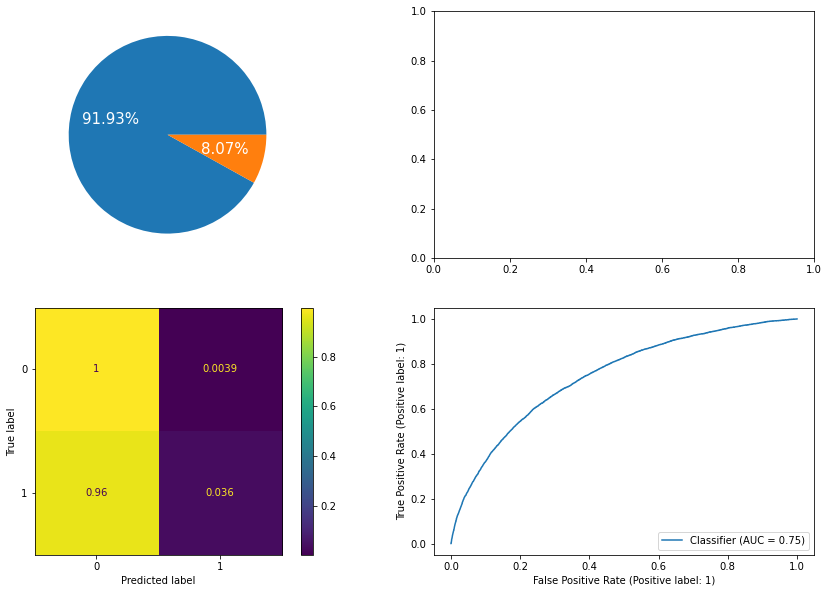

In [30]:
#let's try to change the cost function
from sklearn.metrics import auc
pipe.set_params(classifier__eval_metric = auc)

fit_and_score(df, df_y, pipe)

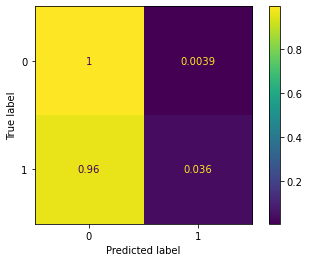

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

#pipe.set_params(classifier__n_estimators = grid.best_params_)

ypred = pipe.predict(xtest)

ConfusionMatrixDisplay.from_predictions(ytest, ypred, normalize = 'true')

plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70735
           1       0.45      0.04      0.07      6143

    accuracy                           0.92     76878
   macro avg       0.68      0.52      0.51     76878
weighted avg       0.88      0.92      0.89     76878



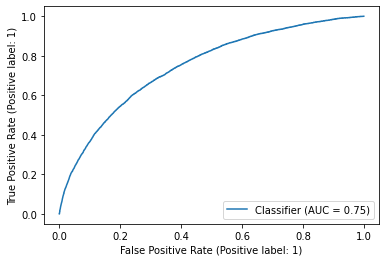

In [13]:
from sklearn.metrics import RocCurveDisplay

yproba = pipe.predict_proba(xtest)

RocCurveDisplay.from_predictions(ytest, yproba[:,1])

plt.show()

In [15]:
pipe.set_params(classifier__n_estimators = grid.best_params_['classifier__n_estimators'])

pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9196389084003226

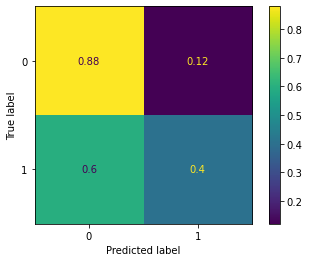

<Figure size 432x288 with 0 Axes>

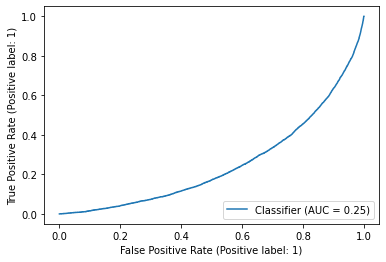

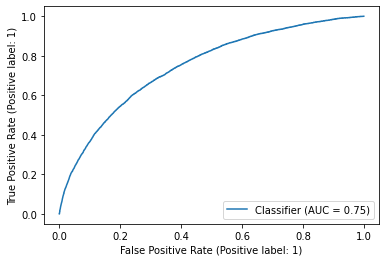

In [41]:
ypred = pipe.predict(xtest)

ConfusionMatrixDisplay.from_predictions(ytest, ypred, normalize = 'true')

plt.show()
plt.clf()
RocCurveDisplay.from_predictions(ytest, yproba[:,0])
plt.show()
RocCurveDisplay.from_predictions(ytest, yproba[:,1])
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     70735
           1       0.25      0.35      0.29      6143

    accuracy                           0.86     76878
   macro avg       0.60      0.63      0.61     76878
weighted avg       0.89      0.86      0.87     76878



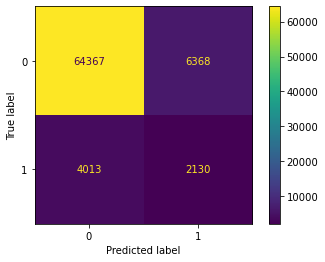

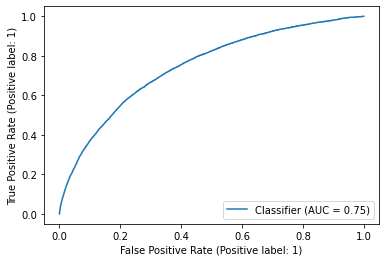

In [62]:
#let's try with weighted xgb
xgboost_w = xgb.XGBClassifier(scale_pos_weight=5)

pipe_w = Pipeline(steps=[("scaler", scaler), ('classifier', xgboost_w)])
pipe_w.fit(xtrain, ytrain)

ypred_w = pipe_w.predict(xtest)
yproba_w = pipe_w.predict_proba(xtest)
print(classification_report(ytest, ypred_w))
ConfusionMatrixDisplay.from_predictions(ytest, ypred_w)
RocCurveDisplay.from_predictions(ytest, yproba_w[:,1])
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, yproba_w[:,1])

0.7199314283578622

In [37]:
weights = np.arange(10, 100, 10)
param_grid = {'classifier__scale_pos_weight' : weights}

grid = GridSearchCV(pipe_w, param_grid, scoring = 'roc_auc', verbose = 2)
grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(grid.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................classifier__scale_pos_weight=10; total time=  41.1s
[CV] END ....................classifier__scale_pos_weight=10; total time=  41.4s
[CV] END ....................classifier__scale_pos_weight=10; total time=  42.2s
[CV] END ....................classifier__scale_pos_weight=10; total time=  41.5s
[CV] END ....................classifier__scale_pos_weight=10; total time=  41.9s
[CV] END ....................classifier__scale_pos_weight=20; total time=  42.0s
[CV] END ....................classifier__scale_pos_weight=20; total time=  47.7s
[CV] END ....................classifier__scale_pos_weight=20; total time=  47.4s
[CV] END ....................classifier__scale_pos_weight=20; total time=  51.4s
[CV] END ....................classifier__scale_pos_weight=20; total time=  49.9s
[CV] END ....................classifier__scale_pos_weight=30; total time=  49.7s
[CV] END ....................classifier__scale_po

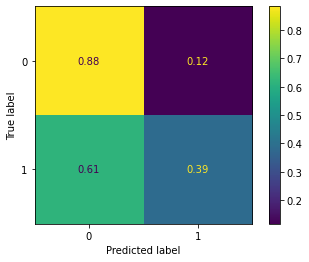

In [27]:
ConfusionMatrixDisplay.from_predictions(ytest, ypred_w, normalize = 'true')

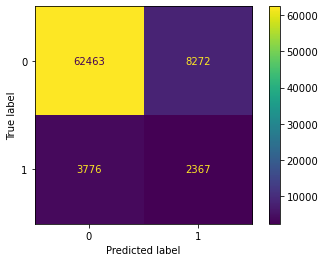

In [29]:
ConfusionMatrixDisplay.from_predictions(ytest, ypred_w, )